In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUMBER_OF_CLASSES=5
BATCH_SIZE=32 # using minibatch of 32 samples

gabriel_features = np.genfromtxt('../data/processed/train_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)

(10000, 116) (10000, 5)


In [2]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

Big question:
* Is it worthwhile to center data?
* Is it worthwhile to scale data or normalize to (0, 1) range?
For later!


EDIT:
First answer: FOR RELU YOU NEED TO SCALE FOR (0,1) AND FOR TANH FOR (-1,1) OTHERWISE IT WON'T WORK!

In [10]:
input_shape = (number_of_features,) # need to pass that comma, as otherwise it'd be evaluated as simple int i.e. type((5))==int, type((4,))==tuple
model = tf.keras.Sequential(
    [
    tf.keras.Input(shape=input_shape),
       tf.keras.layers.Dense(756, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(756, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(756, activation='relu', kernel_initializer='he_normal'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(units=NUMBER_OF_CLASSES, activation='softmax', kernel_initializer='glorot_normal')
    ]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 756)            │        88,452 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 756)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 756)            │       572,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 756)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 756)            │       572,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 756)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │         3,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,821 (4.72 MB)

 Trainable params: 1,236,821 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.0, nesterov=True), # stochastic gradient descent, but can specify batch size.
    loss='categorical_crossentropy',
    metrics=['AUC'],
)

# Train the model with the checkpoint callback
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE, 
    epochs=64,
    callbacks=[checkpoint_callback]
)

Epoch 1/64
243/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7627 - loss: 1.6216
Epoch 1: val_loss improved from inf to 0.71157, saving model to best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.7649 - loss: 1.6086 - val_AUC: 0.9443 - val_loss: 0.7116
Epoch 2/64
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8301 - loss: 1.1525
Epoch 2: val_loss did not improve from 0.71157
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8308 - loss: 1.1500 - val_AUC: 0.9220 - val_loss: 0.8104
Epoch 3/64
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8591 - loss: 1.0429
Epoch 3: val_loss did not improve from 0.71157
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8584 - loss: 1.0450 - val_AUC: 0.8979 - val_loss: 1.0251
Epoch 4/64
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8213 - loss: 1.1602
Epoch 4: val_loss did not improve from 0.71157
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8210 - loss: 1.1608 - val_AUC: 0.9101 - val_loss: 0.9002
Epoch 5/64
245/250 ━━

KeyboardInterrupt: 

In [12]:
history.history.keys()

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])

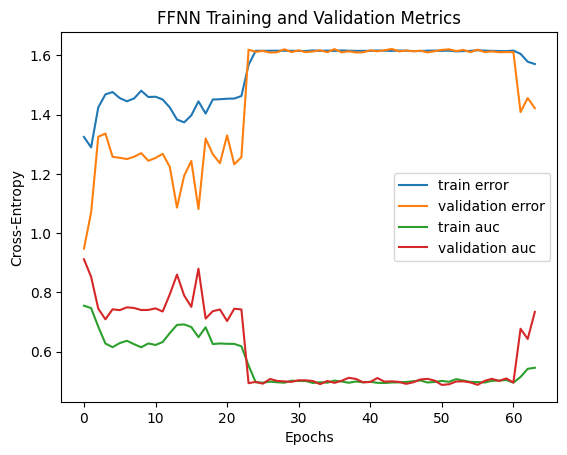

In [13]:


plt.figure()
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='validation error')
plt.plot(history.history['AUC'], label='train auc')
plt.plot(history.history['val_AUC'], label='validation auc')
plt.title('FFNN Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

### Evaluation

In [11]:

gabriel_features = np.genfromtxt('../data/processed/test_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)

(5000, 121) (5000, 5)


In [12]:
# load model from checkpoint best_model.weights.h5
model.load_weights('best_model.weights.h5')
# evaluate the model
loss, auc = model.evaluate(X, y)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.9178 - loss: 0.8548


In [ ]:

data = np.load('../data/raw/fashion_test.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
# fill nans with zeros
X = np.nan_to_num(X)
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


results = model.evaluate(X, y, batch_size=32)

print('test results:', results)

In [10]:
model.save('../models/v0.01_reference_nn.keras')

# CNN

In [ ]:
from sklearn.model_selection import train_test_split
data = np.load('../data/raw/fashion_train.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)
unique_labels = np.unique(y)
unique_labels

In [ ]:
X.shape

In [ ]:

# Define the neural network architecture
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
        tf.keras.layers.Conv2D(
            16, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(
            32, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

# Print model architecture
model.summary()

# Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True), # stochastic gradient descent, but can specify batch size.
    loss='categorical_crossentropy',
    metrics=['AUC'],
)


# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=32,
)
results = model.evaluate(X_val, y_val, batch_size=32)
import matplotlib.pyplot as plt

In [ ]:

plt.figure()
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='validation error')
plt.plot(history.history['auc'], label='train auc')
plt.plot(history.history['val_auc'], label='validation auc')
plt.title('CNN Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

## Evaluation of CNN on the test set.

In [ ]:
data = np.load('../data/raw/fashion_test.npy')
X = data[:, :-1]
y = data[:, -1]

X = X / X.max(axis=0) # alongside rows, per column
# fill nans with zeros
X = np.nan_to_num(X)
y = tf.one_hot(indices=y, depth=NUMBER_OF_CLASSES).numpy()


results = model.evaluate(X, y, batch_size=32)

print('test results:', results)